# Establishment of Antibody Level Cutoffs

The analysis below was performed to establish antibody level cutoffs for differentiating between positive and negative subjects. Cutoffs were chosen on a cohort of controls comprising PCR-positives and pre-pandemic negatives.

In [1]:
# Imports & setup
import os

import numpy as np

import re

import pandas as pd
from pandas import read_csv

import matplotlib
import matplotlib.pyplot as plt
CB_COLOR_CYCLE = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', 
                  '#dede00']
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import seaborn as sns

import scipy.stats as stats

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, SparsePCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (balanced_accuracy_score, r2_score, confusion_matrix, recall_score, 
                             roc_auc_score, average_precision_score, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import plot_partial_dependence

import xgboost as xgb

import networkx as nx

from data_loader import construct_tcell_df, construct_mfi_df
from bootstrap_utils import (run_repeated_CV_XGB, boot_train_test_XGB, boot_train_test_LR, boot_train_test_random, 
                             boot_train_test_feature, boot_feature_selection, boot_feature_selection_LR)
from misc_utils import (print_perf_statistics, count_underexpressed_cells_assay, measure_CV_assay, measure_CV_IAC)
from plotting_utils import (parcoord_plot, plot_errorbars, parcoord_plot_sep, 
                            plot_hist_assay_by_tretament, plot_hist_assay_by_tretament_mfi, 
                            plot_corr_assay, plot_by_symptoms, plot_assay_ecdfs, plot_roc, plotting_setup)

In [2]:
sensitivity = recall_score


def specificity(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 2 - recall_score(y_true, y_pred)


def eval_thresholds(scores, labels):
    ths = np.zeros((len(scores) - 1, ))
    bas = np.zeros((len(scores) - 1, ))
    scores_sorted = np.sort(np.copy(scores))
    for i in range(len(scores) - 1):
        th_i = (scores_sorted[i] + scores_sorted[i + 1]) / 2
        ths[i] = th_i
        preds_i = (scores >= th_i) * 1.0
        bas[i] = balanced_accuracy_score(y_true=labels, y_pred=preds_i)
    return ths, bas

def eval_thresholds_sens(scores, labels):
    ths = np.zeros((len(scores) - 1, ))
    bas = np.zeros((len(scores) - 1, ))
    scores_sorted = np.sort(np.copy(scores))
    for i in range(len(scores) - 1):
        th_i = (scores_sorted[i] + scores_sorted[i + 1]) / 2
        ths[i] = th_i
        preds_i = (scores >= th_i) * 1.0
        bas[i] = sensitivity(y_true=labels, y_pred=preds_i)
    return ths, bas

def eval_thresholds_spec(scores, labels):
    ths = np.zeros((len(scores) - 1, ))
    bas = np.zeros((len(scores) - 1, ))
    scores_sorted = np.sort(np.copy(scores))
    for i in range(len(scores) - 1):
        th_i = (scores_sorted[i] + scores_sorted[i + 1]) / 2
        ths[i] = th_i
        preds_i = (scores >= th_i) * 1.0
        bas[i] = specificity(y_true=labels, y_pred=preds_i)
    return ths, bas

In [3]:
# Load the data
# NB: low_memory=False is needed to deal with mixed type variables
df_pos = read_csv(filepath_or_buffer="data/C+_data.csv", low_memory=False)
df_neg = read_csv(filepath_or_buffer="data/C-_data.csv", low_memory=False)

### RBD IgG

In [4]:
RBD_IgG_pos = df_pos['RBD_IgG'].values.astype(float)
RBD_IgG_pos = RBD_IgG_pos[np.logical_not(np.isnan(RBD_IgG_pos))]
RBD_IgG_neg = df_neg['RBD_IgG'].values.astype(float)
RBD_IgG_neg = RBD_IgG_neg[np.logical_not(np.isnan(RBD_IgG_neg))]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


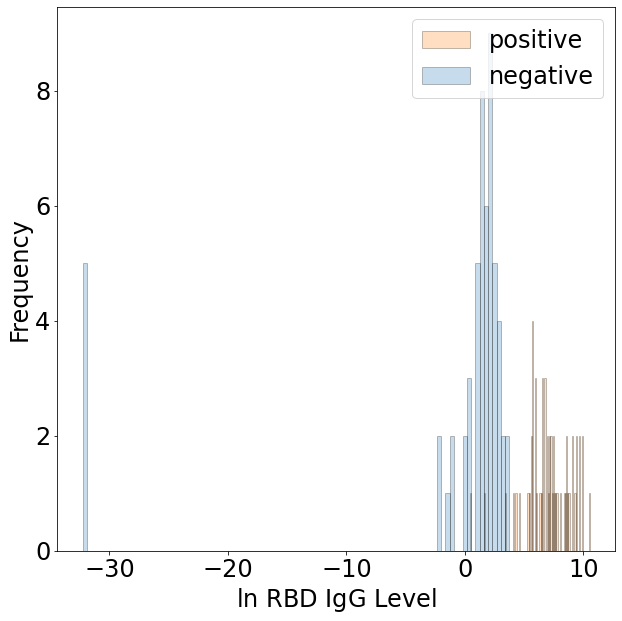

In [5]:
plotting_setup(24)
fig = plt.figure(figsize=(10, 10))
h1 = plt.hist(np.log(RBD_IgG_pos + 1e-14), bins=100, alpha=0.25, color='tab:orange', label='positive', 
              edgecolor='black')
h2 = plt.hist(np.log(RBD_IgG_neg + 1e-14), bins=100, alpha=0.25, color='tab:blue', label='negative', 
              edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('$\ln$ RBD IgG Level')
l = plt.legend(loc='upper right')

In [6]:
RBD_IgG = np.concatenate((RBD_IgG_neg, RBD_IgG_pos))
disease_status = np.concatenate((np.zeros_like(RBD_IgG_neg), np.ones_like(RBD_IgG_pos)))
# Total number of subjects
print(len(RBD_IgG))
print(len(RBD_IgG_neg) / len(RBD_IgG))
print(len(RBD_IgG_pos) / len(RBD_IgG))

112
0.5
0.5


In [7]:
roc_data_RBD = roc_curve(y_true=disease_status, y_score=RBD_IgG)

In [8]:
ths, bas = eval_thresholds(scores=RBD_IgG, labels=disease_status)
ths, senss = eval_thresholds_sens(scores=RBD_IgG, labels=disease_status)
ths, specs = eval_thresholds_spec(scores=RBD_IgG, labels=disease_status)

In [9]:
# Optimal thresholds
print(np.squeeze(ths[np.min(np.argwhere(bas > 0.96)):(np.max(np.argwhere(bas > 0.96)) + 1)]))
print(np.squeeze(np.round(bas[np.min(np.argwhere(bas > 0.96)):(np.max(np.argwhere(bas > 0.96)) + 1)], 3)))

[27.2  31.7  38.8  52.75 67.5 ]
[0.964 0.955 0.964 0.973 0.964]


In [10]:
print(np.squeeze(np.round(senss[np.min(np.argwhere(bas > 0.96)):(np.max(np.argwhere(bas > 0.96)) + 1)], 3)))

[0.964 0.946 0.946 0.946 0.929]


In [11]:
print(np.squeeze(np.round(specs[np.min(np.argwhere(bas > 0.96)):(np.max(np.argwhere(bas > 0.96)) + 1)], 3)))

[0.964 0.964 0.982 1.    1.   ]


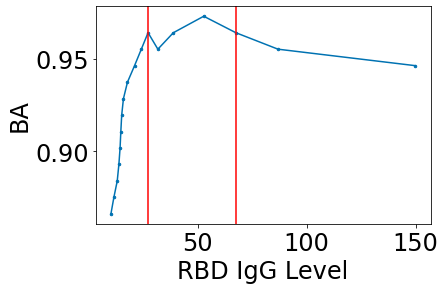

In [12]:
plt.plot(ths[np.logical_and(ths >= 10, ths <= 150)], bas[np.logical_and(ths >= 10, ths <= 150)], 
         marker='o', markersize=2.5)
plt.xlabel('RBD IgG Level')
_ = plt.ylabel('BA')
opt_th = np.squeeze(np.round(ths[np.min(np.argwhere(bas > 0.96)):(np.max(np.argwhere(bas > 0.96)) + 1)], 4))
plt.axvline(opt_th[0], c='red')
_ = plt.axvline(opt_th[-1], c='red')

### N IgG

In [13]:
N_IgG_pos = df_pos['N_IgG'].values.astype(float)
N_IgG_pos = N_IgG_pos[np.logical_not(np.isnan(N_IgG_pos))]
N_IgG_neg = df_neg['N_IgG'].values.astype(float)
N_IgG_neg = N_IgG_neg[np.logical_not(np.isnan(N_IgG_neg))]

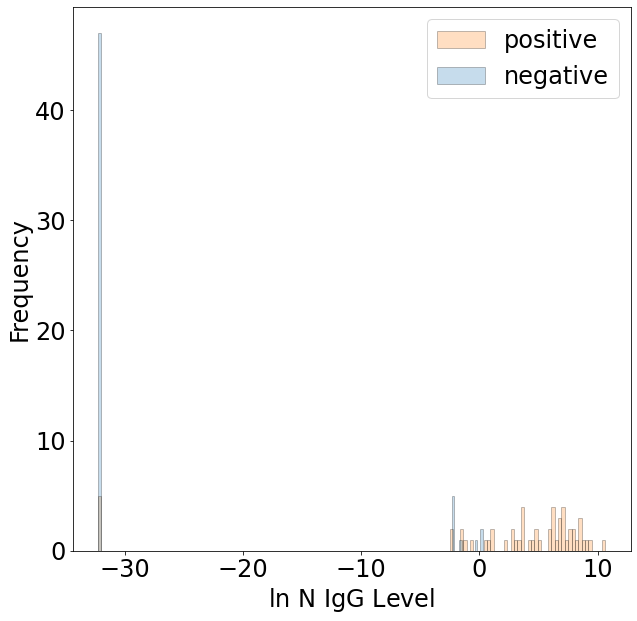

In [14]:
plotting_setup(24)
fig = plt.figure(figsize=(10, 10))
h1 = plt.hist(np.log(N_IgG_pos + 1e-14), bins=150, alpha=0.25, color='tab:orange', label='positive', 
              edgecolor='black')
h2 = plt.hist(np.log(N_IgG_neg + 1e-14), bins=150, alpha=0.25, color='tab:blue', label='negative', 
              edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('$\ln$ N IgG Level')
plt.legend(loc='upper right')

In [15]:
N_IgG = np.concatenate((N_IgG_neg, N_IgG_pos))
disease_status = np.concatenate((np.zeros_like(N_IgG_neg), np.ones_like(N_IgG_pos)))
# Total number of subjects
print(len(N_IgG))
print(len(N_IgG_neg) / len(N_IgG))
print(len(N_IgG_pos) / len(N_IgG))

112
0.5
0.5


In [16]:
roc_data_N = roc_curve(y_true=disease_status, y_score=N_IgG)

In [17]:
ths, bas = eval_thresholds(scores=N_IgG, labels=disease_status)
ths, senss = eval_thresholds_sens(scores=N_IgG, labels=disease_status)
ths, specs = eval_thresholds_spec(scores=N_IgG, labels=disease_status)

In [18]:
# Optimal thresholds
print(np.squeeze(np.round(ths[np.min(np.argwhere(bas >= 0.866)):(np.max(np.argwhere(bas >= 0.866)) + 1)], 3)))
print(np.squeeze(np.round(bas[np.min(np.argwhere(bas >= 0.866)):(np.max(np.argwhere(bas >= 0.866)) + 1)], 3)))

[0.05 0.1  0.1  0.1  0.1  0.1  0.1  0.15 0.2  0.2  0.25 0.45 0.7  1.
 1.25 1.45 1.75 2.5  3.15 6.75]
[0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.902 0.902 0.902 0.893 0.884
 0.875 0.884 0.893 0.902 0.893 0.884 0.875 0.866]


In [19]:
print(np.squeeze(np.round(senss[np.min(np.argwhere(bas >= 0.866)):(np.max(np.argwhere(bas >= 0.866)) + 1)], 3)))

[0.911 0.911 0.911 0.911 0.911 0.911 0.911 0.875 0.875 0.875 0.839 0.821
 0.804 0.804 0.804 0.804 0.786 0.768 0.75  0.732]


In [20]:
print(np.squeeze(np.round(specs[np.min(np.argwhere(bas >= 0.866)):(np.max(np.argwhere(bas >= 0.866)) + 1)], 3)))

[0.839 0.839 0.839 0.839 0.839 0.839 0.839 0.929 0.929 0.929 0.946 0.946
 0.946 0.964 0.982 1.    1.    1.    1.    1.   ]


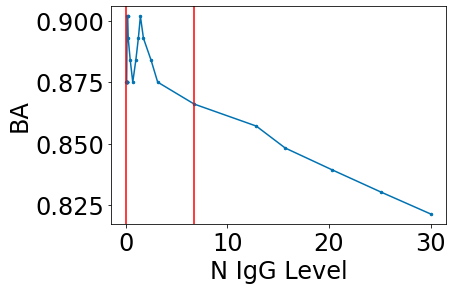

In [21]:
plt.plot(ths[np.logical_and(ths >= 0.005, ths <= 30)], bas[np.logical_and(ths >= 0.005, ths <= 30)], 
         marker='o', markersize=2.5)
plt.xlabel('N IgG Level')
_ = plt.ylabel('BA')
opt_th = np.squeeze(np.round(ths[np.min(np.argwhere(bas > 0.865)):(np.max(np.argwhere(bas > 0.865)) + 1)], 4))
plt.axvline(opt_th[0], c='red')
_ = plt.axvline(opt_th[-1], c='red')

### S2 IgG

In [22]:
S2_IgG_pos = df_pos['S2_IgG'].values.astype(float)
S2_IgG_pos = S2_IgG_pos[np.logical_not(np.isnan(S2_IgG_pos))]
S2_IgG_neg = df_neg['S2_IgG'].values.astype(float)
S2_IgG_neg = S2_IgG_neg[np.logical_not(np.isnan(S2_IgG_neg))]

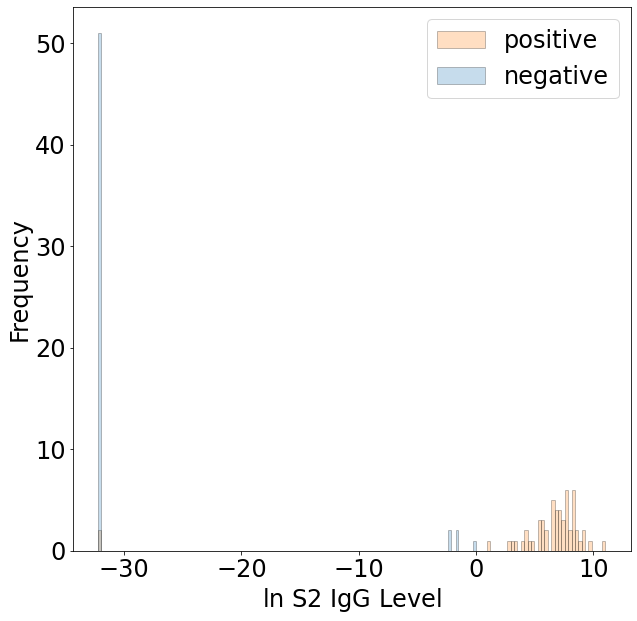

In [23]:
plotting_setup(24)
fig = plt.figure(figsize=(10, 10))
h1 = plt.hist(np.log(S2_IgG_pos + 1e-14), bins=150, alpha=0.25, color='tab:orange', label='positive', 
              edgecolor='black')
h2 = plt.hist(np.log(S2_IgG_neg + 1e-14), bins=150, alpha=0.25, color='tab:blue', label='negative', 
              edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('$\ln$ S2 IgG Level')
plt.legend(loc='upper right')

In [24]:
S2_IgG = np.concatenate((S2_IgG_neg, S2_IgG_pos))
disease_status = np.concatenate((np.zeros_like(S2_IgG_neg), np.ones_like(S2_IgG_pos)))
# Total number of subjects
len(S2_IgG)
print(len(S2_IgG))
print(len(S2_IgG_neg) / len(S2_IgG))
print(len(S2_IgG_pos) / len(S2_IgG))

112
0.5
0.5


In [25]:
roc_data_S2 = roc_curve(y_true=disease_status, y_score=S2_IgG)

In [26]:
ths, bas = eval_thresholds(scores=S2_IgG, labels=disease_status)
ths, senss = eval_thresholds_sens(scores=S2_IgG, labels=disease_status)
ths, specs = eval_thresholds_spec(scores=S2_IgG, labels=disease_status)

In [27]:
# Optimal thresholds
print(np.squeeze(np.round(ths[np.min(np.argwhere(bas > 0.97)):(np.max(np.argwhere(bas > 0.97)) + 1)], 4)))
print(np.squeeze(np.round(bas[np.min(np.argwhere(bas > 0.97)):(np.max(np.argwhere(bas > 0.97)) + 1)], 3)))

[0.6  1.85 8.9 ]
[0.973 0.982 0.973]


In [28]:
print(np.squeeze(np.round(senss[np.min(np.argwhere(bas > 0.97)):(np.max(np.argwhere(bas > 0.97)) + 1)], 3)))

[0.964 0.964 0.946]


In [29]:
print(np.squeeze(np.round(specs[np.min(np.argwhere(bas > 0.97)):(np.max(np.argwhere(bas > 0.97)) + 1)], 3)))

[0.982 1.    1.   ]


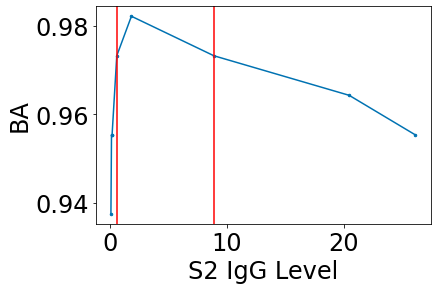

In [30]:
plt.plot(ths[np.logical_and(ths >= 0.1, ths <= 30)], bas[np.logical_and(ths >= 0.1, ths <= 30)], 
         marker='o', markersize=2.5)
plt.xlabel('S2 IgG Level')
_ = plt.ylabel('BA')
opt_th = np.squeeze(np.round(ths[np.min(np.argwhere(bas > 0.97)):(np.max(np.argwhere(bas > 0.97)) + 1)], 4))
plt.axvline(opt_th[0], c='red')
_ = plt.axvline(opt_th[-1], c='red')

### S1 IgG

In [31]:
S1_IgG_pos = df_pos['S1_IgG'].values.astype(float)
S1_IgG_pos = S1_IgG_pos[np.logical_not(np.isnan(S1_IgG_pos))]
S1_IgG_neg = df_neg['S1_IgG'].values.astype(float)
S1_IgG_neg = S1_IgG_neg[np.logical_not(np.isnan(S1_IgG_neg))]

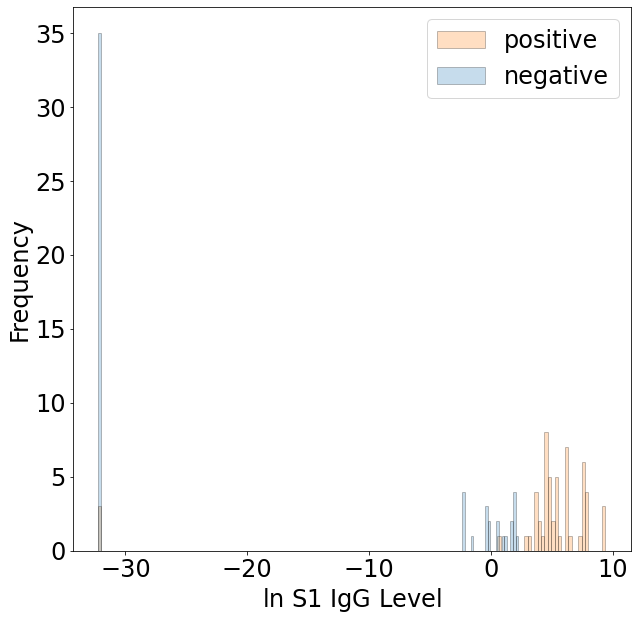

In [32]:
plotting_setup(24)
fig = plt.figure(figsize=(10, 10))
h1 = plt.hist(np.log(S1_IgG_pos + 1e-14), bins=150, alpha=0.25, color='tab:orange', label='positive', 
              edgecolor='black')
h2 = plt.hist(np.log(S1_IgG_neg + 1e-14), bins=150, alpha=0.25, color='tab:blue', label='negative', 
              edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('$\ln$ S1 IgG Level')
plt.legend(loc='upper right')

In [33]:
S1_IgG = np.concatenate((S1_IgG_neg, S1_IgG_pos))
disease_status = np.concatenate((np.zeros_like(S1_IgG_neg), np.ones_like(S1_IgG_pos)))
# Total number of subjects
print(len(S1_IgG))
print(len(S1_IgG_neg) / len(S1_IgG))
print(len(S1_IgG_pos) / len(S1_IgG))

112
0.5
0.5


In [34]:
roc_data_S1 = roc_curve(y_true=disease_status, y_score=S1_IgG)

In [35]:
ths, bas = eval_thresholds(scores=S1_IgG, labels=disease_status)
ths, senss = eval_thresholds_sens(scores=S1_IgG, labels=disease_status)
ths, specs = eval_thresholds_spec(scores=S1_IgG, labels=disease_status)

In [36]:
# Optimal thresholds
print(np.squeeze(np.round(ths[np.min(np.argwhere(bas > 0.945)):(np.max(np.argwhere(bas > 0.945)) + 1)], 4)))
print(np.squeeze(np.round(bas[np.min(np.argwhere(bas > 0.945)):(np.max(np.argwhere(bas > 0.945)) + 1)], 3)))

[ 7.1   8.3  14.3  22.5  33.45]
[0.946 0.955 0.964 0.955 0.946]


In [37]:
print(np.squeeze(np.round(senss[np.min(np.argwhere(bas > 0.945)):(np.max(np.argwhere(bas > 0.945)) + 1)], 3)))

[0.929 0.929 0.929 0.911 0.893]


In [38]:
print(np.squeeze(np.round(specs[np.min(np.argwhere(bas > 0.945)):(np.max(np.argwhere(bas > 0.945)) + 1)], 3)))

[0.964 0.982 1.    1.    1.   ]


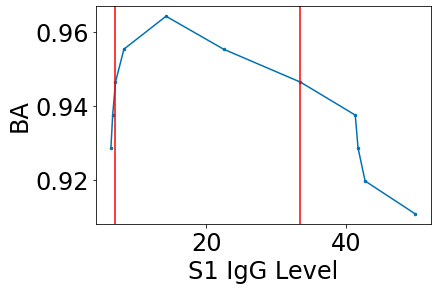

In [39]:
plt.plot(ths[np.logical_and(ths >= 6, ths <= 50)], bas[np.logical_and(ths >= 6, ths <= 50)], 
         marker='o', markersize=2.5)
plt.xlabel('S1 IgG Level')
_ = plt.ylabel('BA')
opt_th = np.squeeze(np.round(ths[np.min(np.argwhere(bas > 0.945)):(np.max(np.argwhere(bas > 0.945)) + 1)], 4))
plt.axvline(opt_th[0], c='red')
_ = plt.axvline(opt_th[-1], c='red')

### nAB

In [40]:
nAB_pos = df_pos['nAb'].values.astype(float)
nAB_pos = nAB_pos[np.logical_not(np.isnan(nAB_pos))]
nAB_neg = df_neg['nAb'].values.astype(float)
nAB_neg = nAB_neg[np.logical_not(np.isnan(nAB_neg))]

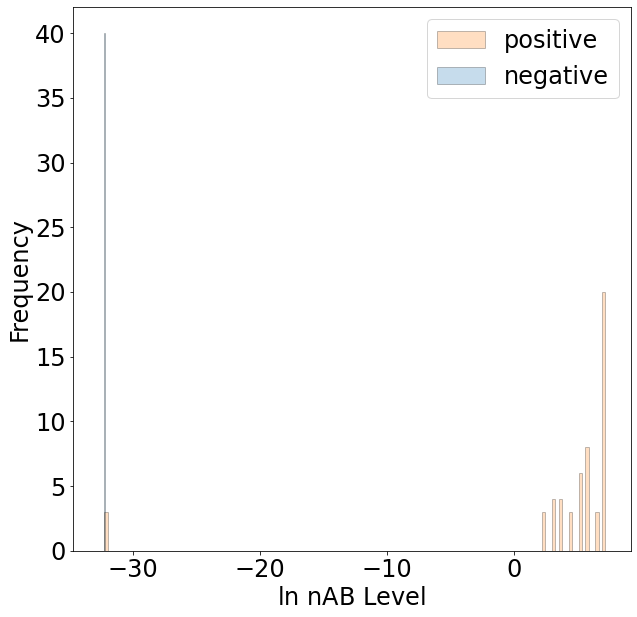

In [41]:
plotting_setup(24)
fig = plt.figure(figsize=(10, 10))
h1 = plt.hist(np.log(nAB_pos + 1e-14), bins=150, alpha=0.25, color='tab:orange', label='positive', 
              edgecolor='black')
h2 = plt.hist(np.log(nAB_neg + 1e-14), bins=150, alpha=0.25, color='tab:blue', label='negative', 
              edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('$\ln$ nAB Level')
plt.legend(loc='upper right')

In [42]:
nAB = np.concatenate((nAB_neg, nAB_pos))
disease_status = np.concatenate((np.zeros_like(nAB_neg), np.ones_like(nAB_pos)))
# Total number of subjects
print(len(nAB))
print(len(nAB_neg) / len(nAB))
print(len(nAB_pos) / len(nAB))

94
0.425531914893617
0.574468085106383


In [43]:
roc_data_nAB = roc_curve(y_true=disease_status, y_score=nAB)

In [44]:
ths, bas = eval_thresholds(scores=nAB, labels=disease_status)
ths, senss = eval_thresholds_sens(scores=nAB, labels=disease_status)
ths, specs = eval_thresholds_spec(scores=nAB, labels=disease_status)

In [45]:
# Optimal thresholds
print(np.squeeze(np.round(ths[np.min(np.argwhere(bas > 0.94)):(np.max(np.argwhere(bas > 0.94)) + 1)], 4)))
print(np.squeeze(np.round(bas[np.min(np.argwhere(bas > 0.94)):(np.max(np.argwhere(bas > 0.94)) + 1)], 3)))

[ 5. 10. 10. 15. 20. 20. 20.]
[0.972 0.972 0.972 0.944 0.944 0.944 0.944]


In [46]:
print(np.squeeze(np.round(senss[np.min(np.argwhere(bas > 0.94)):(np.max(np.argwhere(bas > 0.94)) + 1)], 3)))

[0.944 0.944 0.944 0.889 0.889 0.889 0.889]


In [47]:
print(np.squeeze(np.round(specs[np.min(np.argwhere(bas > 0.94)):(np.max(np.argwhere(bas > 0.94)) + 1)], 3)))

[1. 1. 1. 1. 1. 1. 1.]


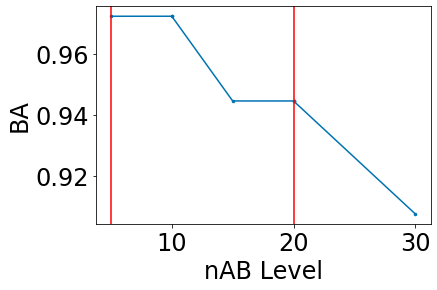

In [48]:
plt.plot(ths[np.logical_and(ths >= 0.000005, ths <= 30)], bas[np.logical_and(ths >= 0.000005, ths <= 30)], 
         marker='o', markersize=2.5)
plt.xlabel('nAB Level')
_ = plt.ylabel('BA')
opt_th = np.squeeze(np.round(ths[np.min(np.argwhere(bas > 0.94)):(np.max(np.argwhere(bas > 0.94)) + 1)], 4))
plt.axvline(opt_th[0], c='red')
_ = plt.axvline(opt_th[-1], c='red')

### Compound 

In [49]:
RBD_pres_pos = np.logical_not(np.isnan(df_pos['RBD_IgG'].values.astype(float)))
N_pres_pos = np.logical_not(np.isnan(df_pos['N_IgG'].values.astype(float)))
S1_pres_pos = np.logical_not(np.isnan(df_pos['S1_IgG'].values.astype(float)))
S2_pres_pos = np.logical_not(np.isnan(df_pos['S2_IgG'].values.astype(float)))
incl_pos = np.logical_and(RBD_pres_pos, np.logical_and(N_pres_pos, np.logical_and(S1_pres_pos, S2_pres_pos)))

In [50]:
RBD_pres_neg = np.logical_not(np.isnan(df_neg['RBD_IgG'].values.astype(float)))
N_pres_neg = np.logical_not(np.isnan(df_neg['N_IgG'].values.astype(float)))
S1_pres_neg = np.logical_not(np.isnan(df_neg['S1_IgG'].values.astype(float)))
S2_pres_neg = np.logical_not(np.isnan(df_neg['S2_IgG'].values.astype(float)))
incl_neg = np.logical_and(RBD_pres_neg, np.logical_and(N_pres_neg, np.logical_and(S1_pres_neg, S2_pres_neg)))

In [51]:
cons_response_pos = np.logical_and(
    (df_pos['RBD_IgG'].values.astype(float) >= 50)[incl_pos], 
    np.logical_or((df_pos['N_IgG'].values.astype(float) >= 5)[incl_pos],
                  np.logical_or((df_pos['S1_IgG'].values.astype(float) >= 20)[incl_pos], 
                                (df_pos['S2_IgG'].values.astype(float) >= 5)[incl_pos])))

In [52]:
cons_response_neg = np.logical_and(
    (df_neg['RBD_IgG'].values.astype(float) >= 50)[incl_neg], 
    np.logical_or((df_neg['N_IgG'].values.astype(float) >= 5)[incl_neg],
                  np.logical_or((df_neg['S1_IgG'].values.astype(float) >= 20)[incl_neg], 
                                (df_neg['S2_IgG'].values.astype(float) >= 5)[incl_neg])))

In [53]:
cons_response = np.concatenate((cons_response_neg, cons_response_pos))
disease_status = np.concatenate((np.zeros_like(cons_response_neg), np.ones_like(cons_response_pos)))

In [54]:
balanced_accuracy_score(y_true=disease_status, y_pred=cons_response)

0.9732142857142857

### ROC Plot

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


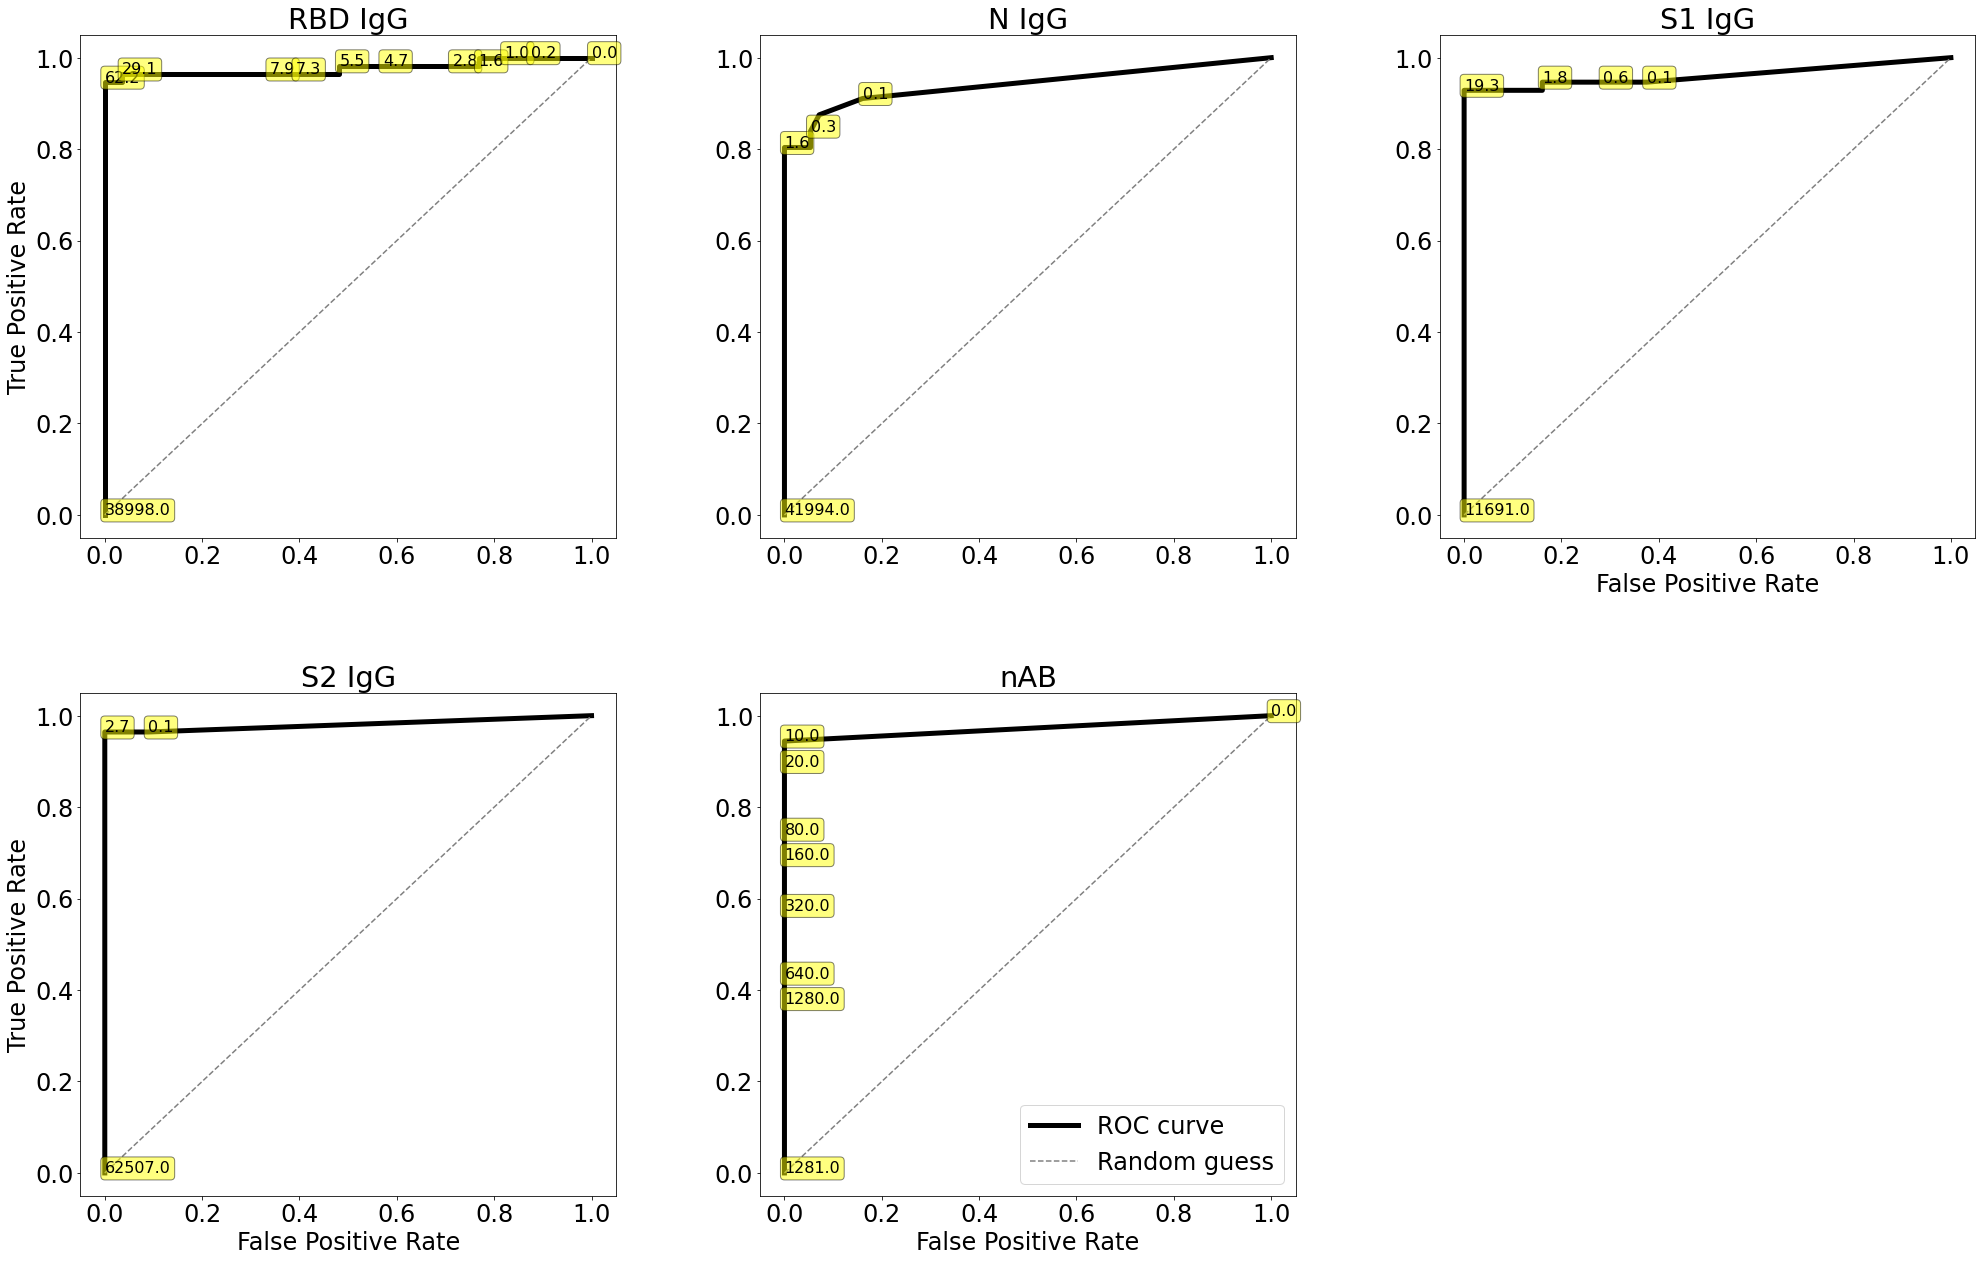

In [55]:
plotting_setup(24)

fig, ax = plt.subplots(2, 3, figsize=(30, 20))

plot_roc(roc_data_RBD[1], roc_data_RBD[0], roc_data_RBD[2], title='RBD IgG', axes=ax[0, 0], label_every=2,
        fpr_label='')
plot_roc(roc_data_N[1], roc_data_N[0], roc_data_N[2], title='N IgG', axes=ax[0, 1], label_every=2, 
         fpr_label='', tpr_label='')
plot_roc(roc_data_S1[1], roc_data_S1[0], roc_data_S1[2], title='S1 IgG', axes=ax[0, 2], label_every=2,
        tpr_label='')
plot_roc(roc_data_S2[1], roc_data_S2[0], roc_data_S2[2], title='S2 IgG', axes=ax[1, 0], label_every=2)
plot_roc(roc_data_nAB[1], roc_data_nAB[0], roc_data_nAB[2], title='nAB', axes=ax[1, 1], label_every=1, 
         tpr_label='')

ax[1, 2].set_axis_off()

l = ax[1, 1].legend(loc='lower right')

plt.tight_layout(pad=4.0)

plt.savefig(fname="figures/rocs_antibodies.svg", dpi=300, bbox_inches='tight')
plt.savefig(fname="figures/rocs_antibodies.pdf", dpi=300, bbox_inches='tight')